In [1]:
from datasets.image_data import ImageDataset
from datasets.data import SkinLesionDataset
from datasets.split_data import DataSplitter
from models.transform import get_transforms
from models.unet import UNet
# from models.attention_unet import AttUNet
from models.trans_unet import TransUNet
from results.plots import plot_img_mask_pred
from torch.utils.data import DataLoader
import torch

c:\Users\user\Deep Learning\melanoma-segmentation-and-classification\venv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Test the ImageDataset class
base_dir = "data"
image_folder = "ISIC-2017_Training_Data"
gt_folder = "ISIC-2017_Training_Part1_GroundTruth"
model = "unet"
split_train = 0.8
split_val = 0.1
split_test = 0.1
image_size = 128
batch_size = 16

In [3]:
# Recieve the image and ground truth paths
dataset_paths = ImageDataset(base_dir, image_folder, gt_folder)
print("Retrieving image and ground truth paths...")
print(dataset_paths)
# Split the data into training, validation, and testing sets (Paths)
image_paths, gt_paths = dataset_paths.get_image_and_gt_paths()

split = DataSplitter(
    image_paths,
    gt_paths,
    split_train,
    split_val,
    split_test,
)
img_train_p, img_val_p, img_test_p, gt_train_p, gt_val_p, gt_test_p = split.split_data()

# Get the train test and validation datasets based on the paths
train_dataset = SkinLesionDataset(
    img_train_p, gt_train_p, transform=get_transforms("train", image_size)
)
val_dataset = SkinLesionDataset(
    img_val_p, gt_val_p, transform=get_transforms("test", image_size)
)
test_dataset = SkinLesionDataset(
    img_test_p, gt_test_p, transform=get_transforms("test", image_size)
)

# Get the train test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Retrieving image and ground truth paths...


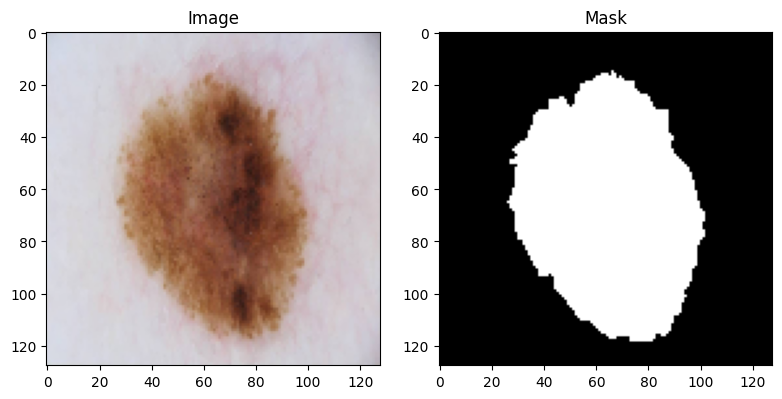

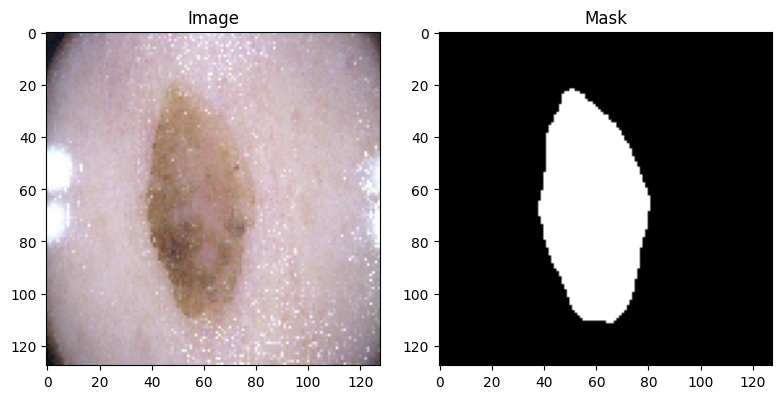

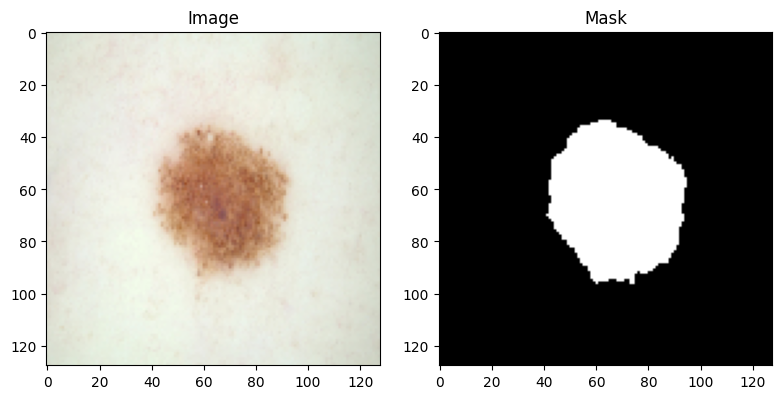

In [5]:
plot_img_mask_pred(train_dataset)
plot_img_mask_pred(val_dataset)
plot_img_mask_pred(test_dataset)


# Train Model

In [ ]:
!nvidia-smi

In [6]:
model = UNet(3, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() >= 1:
    print("Using", torch.cuda.device_count(), "GPUs.")
    model = torch.nn.DataParallel(model)
    model.cuda()
# Check if the model is on the GPU



In [7]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [ ]:
#Define Optimizer and Loss Function
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Train the model
for epoch in range(10):
    model.train()
    for i, (images, masks) in enumerate(train_dataloader):
        images=images
        images = images.to(device)
        print(images.shape)
        masks = masks.to(device).float()
        print(masks.shape)
        optimizer.zero_grad()
        outputs = model(images)
        print("Masks stats: ", masks.min(), masks.max(), masks.mean())
        print("Outputs stats: ", outputs.min(), outputs.max(), outputs.mean())
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}"
            )

# Save the model
torch.save(model.state_dict(), "unet.pth")

In [ ]:
model